# Cluster and Time Series Analysis

The kernel involves 2 major analysis:
### 1. Clustering:
*  Involves grouping tweets into 4 categories: ***Economic, Social, Culture*** and ***health*** then performing KMeans clustering on the grouped tweets to observe how they behave.
* There are several ways of approaching the problem of grouping the tweets such as use of hashtags, user description to check on someone's inclination et.c . My approach uses the technique of creating a set of words that can be confidently classified as belonging to a particular category for each of the 4 classes. 
* So the tweets are each compared with the 4 sets and assigned a similarity score. There're 2 main techniques I considered for computing similarity score:
    1. Cosine Similarity: Cosine similarity is a metric used to measure how similar the documents are irrespective of their size.     Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. This would involve creating word vectors for the set of words and all the tweets then performing the cosine similarity. TFIDF (bag of words model) Vectorizer would be ideal for this.
    2. Jaccard Similarity: Jaccard similarity or intersection over union is defined as size of intersection divided by size of union of two sets.
    * Jaccard similarity takes only unique set of words for each sentence / document while cosine similarity takes total length of the vectors. Jaccard similarity is good for cases where duplication does not matter, cosine similarity is good for cases where duplication matters while analyzing text similarity. In our case, context matters more than duplication thus making Jaccard similarity the most appropriate method to use.
* After getting a tweet's score for the 4 classes, the class with the highest score (highest similarity) is where the tweet is classified. There may be a thin line between ***social, economic*** and ***health*** classes given that the words involved in the 3 classes deeply intermarry, thus the scores among the 3 classes will be really close.
* After classifiying the tweets, sums are done across the categories per user then K Means clustering comes in.


### 2. Time Series Analysis:
* Involves use of time data (created_at) to observe the trends in volume of tweets across the months and days of the week. The analysis might be biased given that we're working with most recent 500 tweets of each user, thus majority of the tweets will be from June and July and lowest records being August. Same goes for the weekly analysis, majority of the tweets being recorded on Tuesday, given the data was scraped on Wednesday and lowest record being on Thursday.

***NB***: The tweets collected are not for all the 1k top users. I stopped at around 400 users iInternet issues) thus the data might miss some of the most important figures. But the technique would be the same if I had the full figures, only a different output wold be observed.

## Table of Contents
1. [Libraries](#Libraries)
2. [Merging the Tweets](#Merging-the-tweets-files-into-a-Mega-df.)
3. [Text Classification](#Text-Classification): 
4. [Jaccard Similarity](#Jaccard-Similarity)
5. [Clustered DF](#Clustered-DF)
6. [KMeans](#KMeans-CLustering.)
7. [KMeans with PCA](#KMeans-with-PCA)
8. [Time Series Analysis](#Time-Series-Analysis)



### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import csv
import os
import pandas as pd

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
# import spacy
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# import en_core_web_sm

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

# !pip3 install -U spacy
# !python3 -m spacy download en_core_web_sm

from sklearn.metrics import jaccard_score

# remove warning: A value is trying to be set on a copy of a slice from a DataFrame
pd.options.mode.chained_assignment = None  # default='warn'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wufan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wufan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Merging the tweets files into a Mega df.

In [2]:
# make one mega dataframe of all the tweets

def pivoted_df(paths):
    global dataframes
    dataframes = []
    for path in paths:
        frame = pd.read_csv(path,low_memory=False)

#         names = path.split('/')
#         names= names[-1]
#         names = names.split('_')
#         global name
#         name = names[0]
#         print(name)

        df = pd.DataFrame()
        df['tweets'] = frame['tweet']
        df['screen_name'] = frame['user_screen_name']
#         df.insert(0, 'screen_name', name)
        
        dataframes.append(df)
    mega = pd.concat(dataframes)
    return mega



In [3]:
##DO NOT DELETE, DO NOT RUN.

# n.remove('SokoAnalyst')
# len(n)

In [4]:
file_paths = ['G:/6105_final_project/hashtag_joebiden.csv']

In [5]:
tweets_bowl = pivoted_df(file_paths)
tweets_bowl.shape


(183883, 2)

In [6]:
# tweets_bowl.to_csv('tweet bowl batch 1 - 4.csv')
tweets_bowl.head()

,tweets,screen_name
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,elsollatinonews
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,Biloximeemaw
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,Flag_Wavers
3,@chrislongview Watching and setting dvr. Let’s...,MichelleFerg4
4,#censorship #HunterBiden #Biden #BidenEmails #...,theegoldstate


In [7]:
tweets_bowl.dropna(subset=['tweets'],inplace=True)
tweets_bowl.head()

,tweets,screen_name
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,elsollatinonews
1,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,Biloximeemaw
2,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,Flag_Wavers
3,@chrislongview Watching and setting dvr. Let’s...,MichelleFerg4
4,#censorship #HunterBiden #Biden #BidenEmails #...,theegoldstate


### Text Classification

#### 1. Cleaning the tweets
   lemmatization, tokenizing, removing stopwards, punctuations, hashtags and mentions

In [8]:
# # remove the hashtags, mentions and unwanted characters from the tweet texts
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
#     for i,v in df[text_field].items():
#         print(i, v)
#         re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '', v)
    df[text_field] = df[text_field].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '', elem))  
    return df

clean_tweets = clean_text(tweets_bowl, 'tweets')
clean_tweets.head()

,tweets,screen_name
0,elecciones2020 en florida joebiden dice que d...,elsollatinonews
1,hunterbiden hunterbidenemails joebiden joebide...,Biloximeemaw
2,this is how biden made his trumpisnotamerica,Flag_Wavers
3,watching and setting dvr lets give him bonus ...,MichelleFerg4
4,censorship hunterbiden biden bidenemails biden...,theegoldstate


In [9]:
#remove stopwords, punctuations, lemmatize and tokenize word
# nlp = spacy.load("en_core_web_sm")   #working with english only, no support for swahili
# nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

            
def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
#     for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)


            
tweets_bowl.tweets = tweets_bowl.tweets.apply(furnished)

In [10]:
tweets_bowl.sample(5)

,tweets,screen_name
100315,biden fix broken scotus one many fix front him...,tRumpNitemare
104445,debate2020 joebiden,Hesaiddat
131027,lyingtrump amp supporter think joebiden americ...,"Congressional Staffer retired, Non-Profit Foun..."
45354,trump v biden este 3 de noviembre sigue la mej...,Excelsior
103623,biden never potusthis crazy choice potus r tru...,Ddking5556


#### 2. Defining the set of words.

In [11]:
economy_related_words = '''agriculture infrastructure capitalism trading service sector technology  economical supply 
                          industrialism efficiency frugality retrenchment downsizing   credit debit value 
                         economize   save  economically
                         economies sluggish rise   rising spending conserve trend 
                         low-management  decline   industry impact poor  
                            profession    surplus   fall
                         declining  accelerating interest sectors balance stability productivity increase rates
                            pushing expanding stabilize  rate industrial borrowing struggling
                           deficit predicted    increasing  data
                          economizer analysts investment market-based economy   debt free enterprise
                         medium  exchange metric savepoint scarcity capital bank company stockholder fund business  
                         asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics
                         bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation 
                         quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital
                         mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution
                         bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter 
                         distribution downturn economist'''

In [12]:
social_related_words = '''sociable, gregarious societal friendly society socialization political  sociality 
                        interpersonal  ethnic socially party welfare public community socialist societies development
                            network humans socialism collective personal corporation social constructivism
                        relations volition citizenship brute   attitude rights socio 
                        socioeconomic ethics civic communal marital  sociale socialized communities     
                         policy   unions        
                        institutions values     governmental   organizations jamboree 
                         festivity    fairness  support  care  
                         sides   activism     unsocial psychosocial 
                        socializing psychological distributional  demographic  participation reunion 
                        partygoer partyism festive power network gala housewarming celebration counterparty   social-war
                        particularist interactional ideational asocial'''

In [13]:
culture_related_words  = ''' ethnicity heritage modernity spirituality marxismmaterial culture 
                           ethos nationality humanism romanticism civilisation traditionalism genetics
                        kinship heredity marriage   indigenous  archeology  acculturate  
                       ontogenesis viniculture modern clothes     rooted 
                       cicero societies history roots influence geography historical folk origins 
                       phenomenon teleology ancient aspects perspective liberalism nowadays community style unique prevalent describes 
                         today  origin   modernity beliefs  genre barbarian ethnic 
                       colonization cultural universal organization western-civilization structuralism  culture 
                       heathen pagan transculturation culture peasant classicist nativism anarchy ungrown philosophic cult  
                       consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism  
                       mongolian cosmopolitan epistemology lifestyles diversity chauvinism westernization materialism vernacular 
                       homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse
                       puritanism modernism intellectualism  exclusiveness elitism  colonialism  
                       pentecostalism paganism nationwide expansion rural  auxesis kimono 
                       culturize alethophobia nettlebed japanification  dongyi clannishness insularity hybridity
                       westernisation foreignness worldview exclusionism enculturation ethnocentrism  confucianist vulgarization
                       shintoism  westernism denominationalism    deracination
                        eurocentrism  cosmologies  emotiveness bohemianism territorialism
                       philosophical-doctrine ethnic minority social-darwinism  theory cultural evolution belief systemfolk music 
                       traditional art house karl-marx   theorymedia  
                       film-theory art history museum studies cultural artifact'''

In [14]:
health_related_words = '''disease obesity world health organization medicine nutrition well-being exercise welfare wellness health care public health 
                     nursing stress safety hygiene research social healthy condition aids epidemiology healthiness wellbeing
                     care illness medical dieteducation infectious disease environmental healthcare physical fitness hospitals 
                     health care provider doctors healthy community design insurance sanitation human body patient mental health
                      medicare agriculture health science fitnesshealth policy  weight loss physical therapy psychology pharmacy
                     metabolic organism human lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family
                     eudaimonia eudaemonia air house prevention genetics public families poor needs treatment communicable disease 
                     study protection malaria development food priority management healthful mental provide department administration
                     programs help assistance funding environment improving emergency need program affected schools private mental illness 
                     treat diseases preparedness perinatal fertility sickness veterinary sanitary pharmacists behavioral midwives
                     gerontology infertility hospitalization midwifery cholesterol childcare pediatrician pediatrics medicaid asthma 
                     pensions sicknesses push-up physical education body-mass-index eat well gymnastic apparatus tune up good morning 
                     bathing low blood-pressure heart attack health club ride-bike you feel good eczema urticaria dermatitis sunburn overwork 
                     manufacturing medical sociology need exercise run'''

#### 3. Preprocessing the sets.

 #### Tokenizing and removing stop words from the sets.

In [15]:
# nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

# clean the set of words
            
def furnished(text):
    final_text = []
    for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)


In [16]:
economy = furnished(economy_related_words)
social = furnished(social_related_words)
culture = furnished(culture_related_words)
health = furnished(health_related_words)

#### Removing duplicates

In [17]:
# delete duplicates
string1 = economy
words = string1.split()
economy = " ".join(sorted(set(words), key=words.index))
economy

'agriculture infrastructure capitalism trading service sector technology economical supply industrialism efficiency frugality retrenchment downsizing credit debit value economize save economically economy sluggish rise rising spending conserve trend low-management decline industry impact poor profession surplus fall declining accelerating interest balance stability productivity increase rate pushing expanding stabilize industrial borrowing struggling deficit predicted increasing data economizer analyst investment market-based debt free enterprise medium exchange metric savepoint scarcity capital bank company stockholder fund business asset treasury tourism income contraction employment job upturn deflation macroeconomics bankruptcy exporter hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture mutual plan mortgage lender unemployment crunch central financial 

In [18]:
string1 = social
words = string1.split()
social = " ".join(sorted(set(words), key=words.index))
social

'sociable, gregarious societal friendly society socialization political sociality interpersonal ethnic socially party welfare public community socialist development network human socialism collective personal corporation social constructivism relation volition citizenship brute attitude right socio socioeconomic ethic civic communal marital sociale socialized policy union institution value governmental organization jamboree festivity fairness support care side activism unsocial psychosocial socializing psychological distributional demographic participation reunion partygoer partyism festive power gala housewarming celebration counterparty social-war particularist interactional ideational asocial'

In [19]:
string1 = culture
words = string1.split()
culture = " ".join(sorted(set(words), key=words.index))
culture

'ethnicity heritage modernity spirituality marxismmaterial culture ethos nationality humanism romanticism civilisation traditionalism genetics kinship heredity marriage indigenous archeology acculturate ontogenesis viniculture modern clothes rooted cicero society history root influence geography historical folk origin phenomenon teleology ancient aspect perspective liberalism nowadays community style unique prevalent describes today belief genre barbarian ethnic colonization cultural universal organization western-civilization structuralism heathen pagan transculturation peasant classicist nativism anarchy ungrown philosophic cult consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism mongolian cosmopolitan epistemology lifestyle diversity chauvinism westernization materialism vernacular homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse puritanism modernism intellectualism exclusiveness elitism 

In [20]:
string1 = health
words = string1.split()
health = " ".join(sorted(set(words), key=words.index))
health

'disease obesity world health organization medicine nutrition well-being exercise welfare wellness care public nursing stress safety hygiene research social healthy condition aid epidemiology healthiness wellbeing illness medical dieteducation infectious environmental healthcare physical fitness hospital provider doctor community design insurance sanitation human body patient mental medicare agriculture science fitnesshealth policy weight loss therapy psychology pharmacy metabolic organism lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family eudaimonia eudaemonia air house prevention genetics poor need treatment communicable study protection malaria development food priority management healthful provide department administration program help assistance funding environment improving emergency affected school private treat preparedness perinatal fertility sickness veterinary sanitary pharmacist behavioral midwife gerontology infertility hospitalization 

#### 4. Vectorizing and Standadization.
Necessary if cosine similarity would be used

In [21]:
'''Vectorizing the sets of words, then standardizing them. TFIDF will be used in order to take care of the least 
frequent words. Standardizing is cause TFIDF favors long sentences and there'll be inconsistencies between the length 
of the tweets and the length of set of words.'''


def get_vectors(*strs):
    text = [t for t in strs]
    vectorizer = TfidfVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

In [22]:
socialvector = get_vectors(social)
economic_vector = get_vectors(economy)
culture_vector = get_vectors(culture)
health_vector = get_vectors(health)

G:\Anaconda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass input=['sociable, gregarious societal friendly society socialization political sociality interpersonal ethnic socially party welfare public community socialist development network human socialism collective personal corporation social constructivism relation volition citizenship brute attitude right socio socioeconomic ethic civic communal marital sociale socialized policy union institution value governmental organization jamboree festivity fairness support care side activism unsocial psychosocial socializing psychological distributional demographic participation reunion partygoer partyism festive power gala housewarming celebration counterparty social-war particularist interactional ideational asocial'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
G:\Anaconda\lib\site-pa

In [23]:
## Vectorizing the tweets
tv=TfidfVectorizer()
# tweets_bowl = tweets_bowl.tweets.apply(get_vectors)
# tweets_bowl.head()
tfidf_tweets =tv.fit_transform(tweets_bowl.tweets)

### Jaccard Similarity

In [24]:
'''Jaccard similarity is good for cases where duplication does not matter, 
cosine similarity is good for cases where duplication matters while analyzing text similarity. For two product descriptions, 
it will be better to use Jaccard similarity as repetition of a word does not reduce their similarity.'''

def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)
# jaccard_score(socialvector, economic_vector)

#for similarity of 1 and 2 of column1
# jaccard_similarity('dog lion a dog','dog is cat')


def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores

In [25]:
# economic scores
e_scores = get_scores(economy, tweets_bowl.tweets.to_list())
e_scores[-10:]

[0.7586206896551724,
 0.6,
 0.7,
 0.7,
 0.696969696969697,
 0.7857142857142857,
 0.8,
 0.3333333333333333,
 0.5806451612903226,
 0.7857142857142857]

In [26]:
# social scores
s_scores = get_scores(social, tweets_bowl.tweets.to_list())
s_scores[-10:]

[0.7857142857142857,
 0.6206896551724138,
 0.7241379310344828,
 0.7241379310344828,
 0.71875,
 0.8148148148148148,
 0.8275862068965517,
 0.3448275862068966,
 0.6,
 0.8148148148148148]

In [27]:
# culture scores
c_scores = get_scores(culture, tweets_bowl.tweets.to_list())
c_scores[-10:]

[0.7586206896551724,
 0.6,
 0.7,
 0.7,
 0.696969696969697,
 0.7857142857142857,
 0.8,
 0.3333333333333333,
 0.5806451612903226,
 0.7857142857142857]

In [28]:
# health scores
h_scores = get_scores(health, tweets_bowl.tweets.to_list())
h_scores[:6]

[0.6333333333333333,
 0.6296296296296297,
 0.5769230769230769,
 0.6666666666666666,
 0.6538461538461539,
 0.7857142857142857]

In [29]:
'''new df with names, and the jaccard scores for each group'''

data  = {'names':tweets_bowl.screen_name.to_list(), 'economic_score':e_scores,
         'social_score': s_scores, 'culture_score':c_scores, 'health_scores':h_scores}
scores_df = pd.DataFrame(data)
scores_df.head(20)

,names,economic_score,social_score,culture_score,health_scores
0,elsollatinonews,0.700000,0.666667,0.700000,0.633333
1,Biloximeemaw,0.642857,0.666667,0.642857,0.629630
2,Flag_Wavers,0.535714,0.555556,0.535714,0.576923
3,MichelleFerg4,0.678571,0.703704,0.678571,0.666667
4,theegoldstate,0.607143,0.629630,0.607143,0.653846
5,Dose_Dissonance,0.857143,0.821429,0.857143,0.785714
6,changeillinois,0.766667,0.793103,0.766667,0.758621
7,FreebieDepot,0.633333,0.655172,0.633333,0.678571
8,Kennethuteliv,0.178571,0.185185,0.178571,0.192308
9,JakeRivendale,0.750000,0.777778,0.750000,0.807692


There's a thin line between economy, social and culture.

Pick out the greatest score out of the 4 scores, where the score is greatest, replace it with 1, the rest 0.

In [30]:
'''Actual assigning of classes to the tweets'''

def get_clusters(l1, l2, l3, l4):
    econ = []
    socio = []
    cul = []
    heal = []
    for i, j, k, l in zip(l1, l2, l3, l4):
        m = max(i, j, k, l)
        if m == i:
            econ.append(1)
        else:
            econ.append(0)
        if m == j:
            socio.append(1)
        else:
            socio.append(0)        
        if m == k:
            cul.append(1)
        else:
            cul.append(0)  
        if m == l:
            heal.append(1)
        else:
            heal.append(0)   
            
    return econ, socio, cul, heal

In [31]:
l1 = scores_df.economic_score.to_list()
l2 = scores_df.social_score.to_list()
l3 = scores_df.culture_score.to_list()
l4 = scores_df.health_scores.to_list()

econ, socio, cul, heal = get_clusters(l1, l2, l3, l4)

In [32]:
data = {'name': scores_df.names.to_list(), 'economic':econ, 'social':socio, 'culture':cul, 'health': heal}
cluster_df = pd.DataFrame(data)
cluster_df.head(5)

,name,economic,social,culture,health
0,elsollatinonews,1,0,1,0
1,Biloximeemaw,0,1,0,0
2,Flag_Wavers,0,0,0,1
3,MichelleFerg4,0,1,0,0
4,theegoldstate,0,0,0,1


In [33]:
'''Due to the close similarity between the economic, social and health tweets, some tweets have multiple categories, 
so to take care of that the rows with a sum > 1 will have to share the categories. After this, clustering will take care 
of the fractions'''


a =  cluster_df[['economic', 'social', 'culture', 'health']].sum(axis = 1) > 1
c = cluster_df[['economic', 'social', 'culture', 'health']].sum(axis = 1)
# b = cluster_df.copy()
cluster_df.loc[(a), ['economic','social', 'culture', 'health']] = 1/c

In [34]:
cluster_df.shape

(181846, 5)

### Clustered DF

In [35]:
pivot_clusters = cluster_df.groupby(['name']).sum()
pivot_clusters['economic'] = pivot_clusters['economic'].astype(int)
pivot_clusters['social'] = pivot_clusters['social'].astype(int)
pivot_clusters['culture'] = pivot_clusters['culture'].astype(int)
pivot_clusters['health'] = pivot_clusters['health'].astype(int)
pivot_clusters['total'] = pivot_clusters['health'] + pivot_clusters['culture'] + pivot_clusters['social'] +  pivot_clusters['economic']
pivot_clusters.loc["Total"] = pivot_clusters.sum()  #add a totals row
print(pivot_clusters.shape)
pivot_clusters = pivot_clusters.drop(pivot_clusters[pivot_clusters['total']==0].index)
pivot_clusters.sort_values(by=['total'],ascending=False).head()

(69657, 5)


,economic,social,culture,health,total
name,,,,,
Total,7716,84458,7716,84022,183912
revue2presse,228,393,228,355,1204
greeneyes3470,83,349,83,83,598
JournalistJG,23,104,23,347,497
Hotpage_News,16,46,16,403,481


#### Visualisations

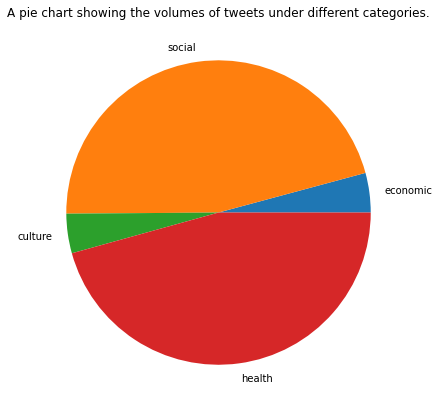

In [36]:
'''A pie chart to show the total number of tweets in each category'''

fig = plt.figure(figsize =(10, 7)) 
a = pivot_clusters.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show() 

* The huge percentage in health could be as a result of the current pandemic, Covid19, everyone is talking about it thus a huge volume of tweets. (The tweets are the most recent 500). 
* The social tweets follow, this could be related to the set of words defined as words related to social. Most of these terms are general, thus if a tweet that maybe was more economy related could have more social words than economy words and thus classified as social, so this is mainnly a bias in the classification method.

Text(0, 0.5, 'total tweets')

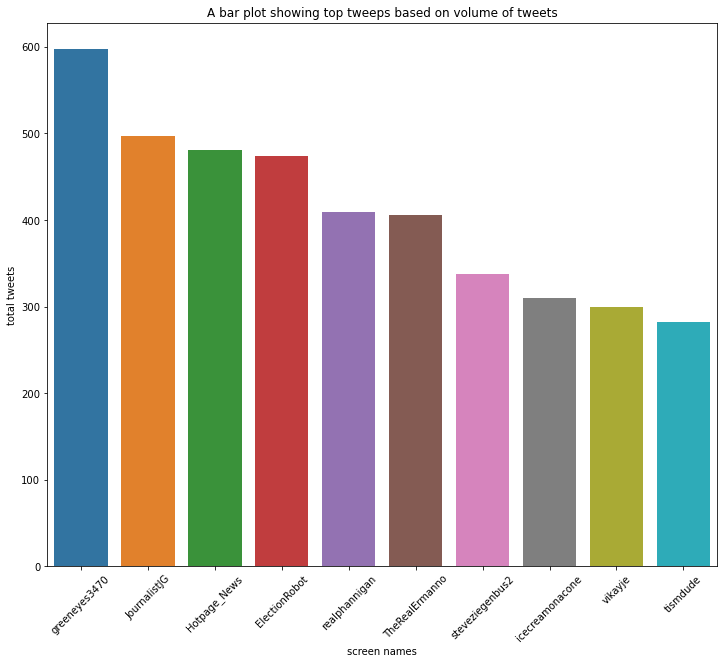

In [37]:
''' Users with most tweets'''

d = pivot_clusters.sort_values(by = 'total', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)
plt.figure(figsize=(12,10))

sns.barplot(x = e.index, y = e.total)
plt.title('A bar plot showing top tweeps based on volume of tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('total tweets')

Text(0, 0.5, 'economy tweets')

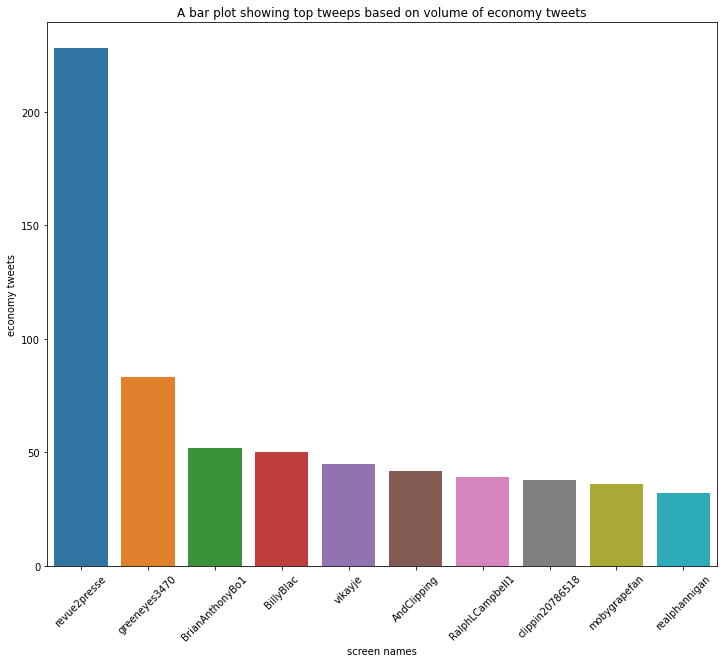

In [38]:
''' Users with most economy tweets'''

d = pivot_clusters.sort_values(by = 'economic', ascending  = False)
e = d.head(11)
e.drop(e.head(1).index, inplace=True)

plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.economic)
plt.title('A bar plot showing top tweeps based on volume of economy tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('economy tweets')

Text(0, 0.5, 'social tweets')

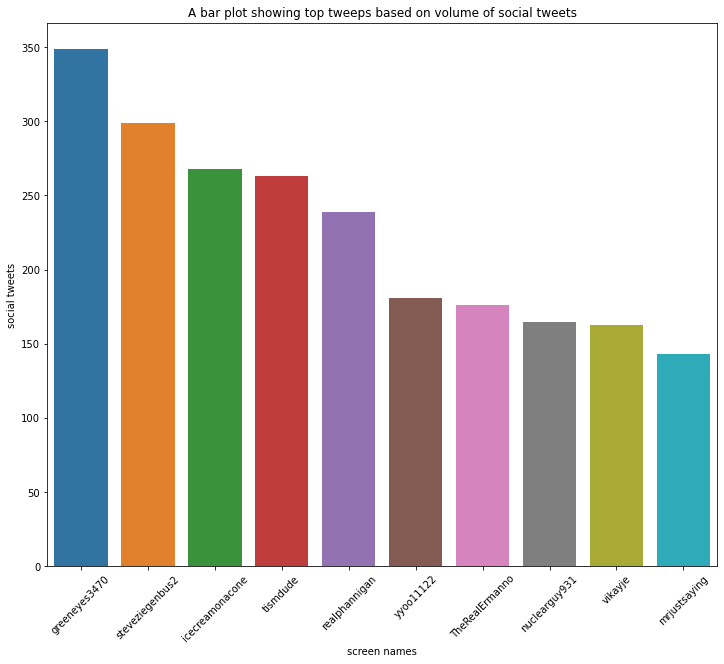

In [39]:
''' Users with most social tweets'''

d = pivot_clusters.sort_values(by = 'social', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)


plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.social)
plt.title('A bar plot showing top tweeps based on volume of social tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('social tweets')

Text(0, 0.5, 'culture tweets')

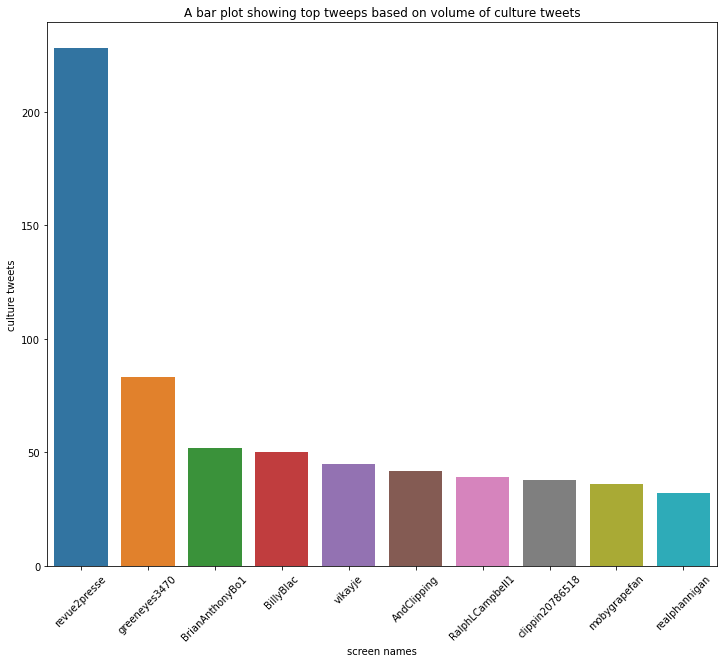

In [40]:
''' Users with most culture tweets'''

d = pivot_clusters.sort_values(by = 'culture', ascending  = False)
e = d.head(11)
e.drop(e.head(1).index, inplace=True)


plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.culture)
plt.title('A bar plot showing top tweeps based on volume of culture tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('culture tweets')

Text(0, 0.5, 'health tweets')

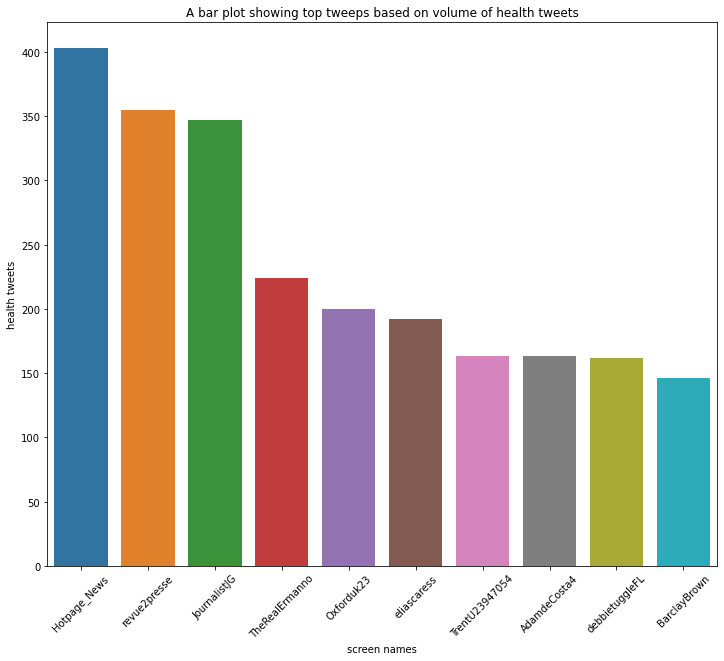

In [41]:
''' Users with most health tweets'''

d = pivot_clusters.sort_values(by = 'health', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)


plt.figure(figsize=(12,10))
sns.barplot(x = e.index, y = e.health)
plt.title('A bar plot showing top tweeps based on volume of health tweets')
plt.xticks(rotation=45)
plt.xlabel('screen names')
plt.ylabel('health tweets')

#### Distribution test and skewness

In [42]:
from statistics import mean
import re
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.preprocessing import StandardScaler


In [43]:
# drop the totals row.
print(pivot_clusters.shape)
pivot_clusters.drop(pivot_clusters.tail(1).index,inplace=True)
print(pivot_clusters.shape)

(62999, 5)
(62998, 5)


G:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.12 and sigma = 1.30



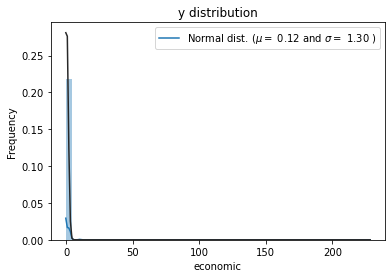

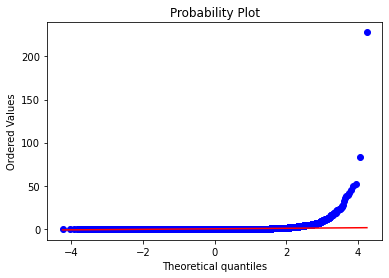

In [44]:
# Target variable
sns.distplot(pivot_clusters.economic , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.economic)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.title('Ecocnomy tweets distribution plot')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.economic, plot=plt)
plt.show()


G:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 1.34 and sigma = 4.99



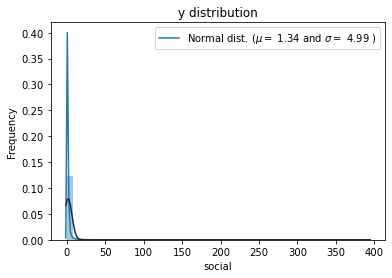

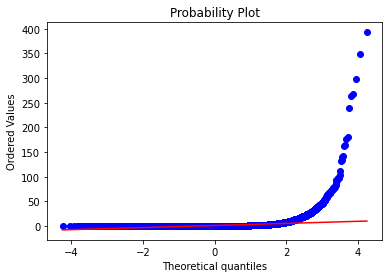

In [45]:
# Target variable
sns.distplot(pivot_clusters.social , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.social)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Social tweets distribution plot')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.social, plot=plt)
plt.show()


right tail (heavy)

G:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 0.12 and sigma = 1.30



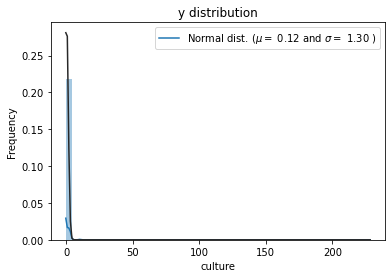

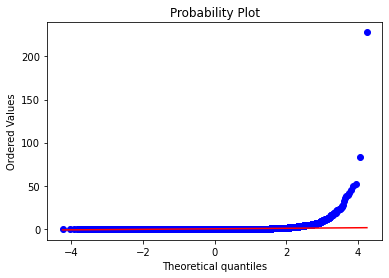

In [46]:
# Target variable
sns.distplot(pivot_clusters.culture , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.culture)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Culture tweets distribution plot')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.culture, plot=plt)
plt.show()


rightly skewed (right tail)

G:\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 1.33 and sigma = 4.94



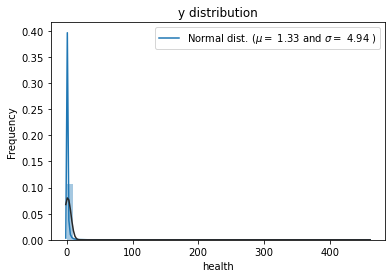

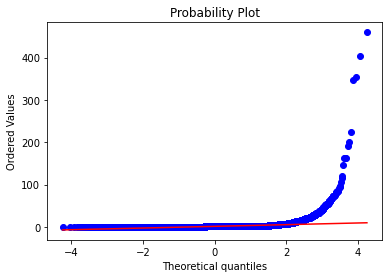

In [47]:
# Target variable
sns.distplot(pivot_clusters.health , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(pivot_clusters.health)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.title('Health tweets distribution plot')
plt.ylabel('Frequency')
plt.title('y distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(pivot_clusters.health, plot=plt)
plt.show()


left tailed

In [48]:
#Normalise skewed features.
# pivot_clusters['economic'] = boxcox1p(pivot_clusters['economic'], boxcox_normmax(pivot_clusters['economic'] + 1))
# pivot_clusters['social'] = boxcox1p(pivot_clusters['social'], boxcox_normmax(pivot_clusters['social'] + 1))
# pivot_clusters['culture'] = boxcox1p(pivot_clusters['culture'], boxcox_normmax(pivot_clusters['culture'] + 1))
# pivot_clusters['health'] = boxcox1p(pivot_clusters['health'], boxcox_normmax(pivot_clusters['health'] + 1))

In [49]:
# f, axes = plt.subplots(2, 2, figsize=(30, 20), sharex=True)
# sns.distplot(x , fit=norm);
# sns.distplot(pivot_clusters.social , ax = axes[0, 1], fit=norm);
# sns.distplot(pivot_clusters.culture , ax = axes[1, 0], fit=norm);
# sns.distplot(pivot_clusters.health , ax = axes[1, 1], fit=norm);

##  KMeans Clustering.

'Distance computation in k-Means weights each dimension equally and hence care must be taken to ensure that unit of dimension shouldn’t distort relative near-ness of observations. Common method is to unit-standardize each dimension individually.' The unit for the tweets are the same, thus no need.

In [50]:
# Standardize features with scaler
# x = pivot_clusters.iloc[:, [0,1,2,3]]
# pivot_clusters['health'] = StandardScaler().fit_transform(pivot_clusters['health'].values.reshape(-1,1))
# pivot_clusters['culture'] = StandardScaler().fit_transform(pivot_clusters['culture'].values.reshape(-1,1))
# pivot_clusters['social'] = StandardScaler().fit_transform(pivot_clusters['social'].values.reshape(-1,1))
# pivot_clusters['economic'] = StandardScaler().fit_transform(pivot_clusters['economic'].values.reshape(-1,1))

In [51]:
from sklearn.cluster import KMeans


### 2D Clusters.

#### * Socio-Economic

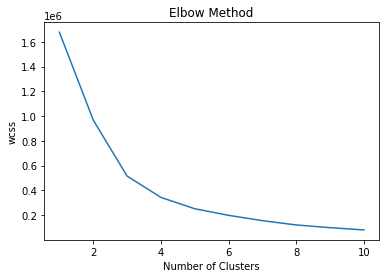

In [52]:
# X = pivot_clusters.iloc[:, [0,1]].values
X = pivot_clusters[['economic', 'social']].values

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

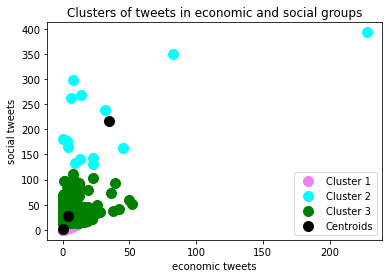

In [53]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
# plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
# plt.scatter(X[Y_kmeans==4, 0], X[Y_kmeans==4, 1], s=100, c='magenta', label= 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in economic and social groups')
plt.xlabel('economic tweets')
plt.ylabel('social tweets')
plt.legend()
plt.show()

#### * Socio-Culture

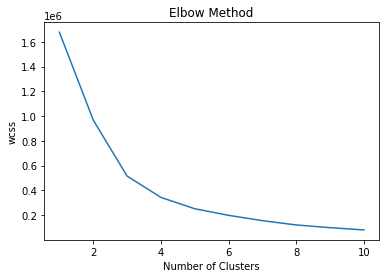

In [54]:
# X = pivot_clusters.iloc[:, [2,3]].values
X = pivot_clusters[['social', 'culture']].values

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

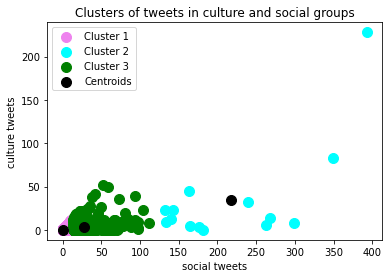

In [55]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
# plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
# plt.scatter(X[Y_kmeans==4, 0], X[Y_kmeans==4, 1], s=100, c='magenta', label= 'Cluster 5')
# plt.scatter(X[Y_kmeans==5, 0], X[Y_kmeans==5, 1], s=100, c='pink', label= 'Cluster 6')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in culture and social groups')
plt.xlabel('social tweets')
plt.ylabel('culture tweets')
plt.legend()
plt.show()

#### * Socio-Health

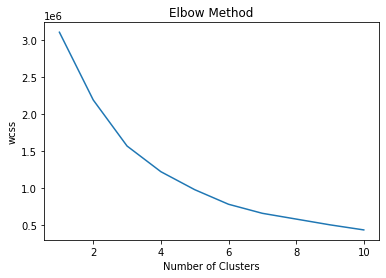

In [56]:
# X = pivot_clusters.iloc[:, [2,4]].values
X = pivot_clusters[['social', 'health']].values

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


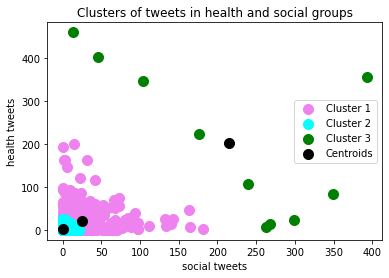

In [57]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
# plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
# plt.scatter(X[Y_kmeans==4, 0], X[Y_kmeans==4, 1], s=100, c='magenta', label= 'Cluster 5')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in health and social groups')
plt.xlabel('social tweets')
plt.ylabel('health tweets')
plt.legend()
plt.show()

#### * Economic-health

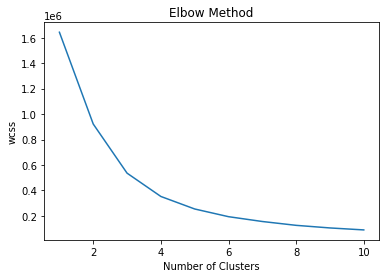

In [58]:
# X = pivot_clusters.iloc[:, [2,4]].values
X = pivot_clusters[['economic', 'health']].values

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


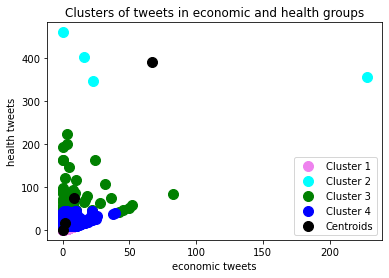

In [59]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
# plt.scatter(X[Y_kmeans==4, 0], X[Y_kmeans==4, 1], s=100, c='magenta', label= 'Cluster 5')
# plt.scatter(X[Y_kmeans==5, 0], X[Y_kmeans==5, 1], s=100, c='pink', label= 'Cluster 6')
# plt.scatter(X[Y_kmeans==6, 0], X[Y_kmeans==6, 1], s=100, c='yellow', label= 'Cluster 7')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in economic and health groups')
plt.xlabel('economic tweets')
plt.ylabel('health tweets')
plt.legend()
plt.show()

####  Economic-Culture

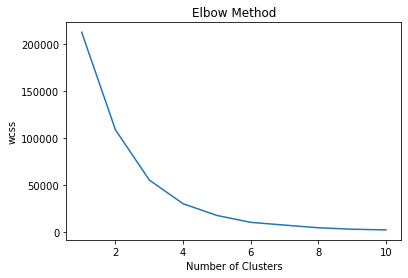

In [60]:
# X = pivot_clusters.iloc[:, [2,4]].values
X = pivot_clusters[['economic', 'culture']].values

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


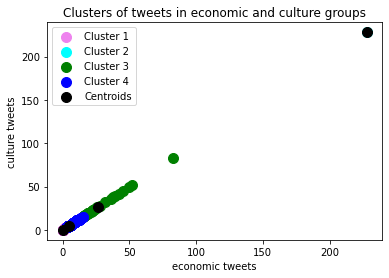

In [61]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=100, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=100, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=100, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=100, c='blue', label= 'Cluster 4')
# plt.scatter(X[Y_kmeans==4, 0], X[Y_kmeans==4, 1], s=100, c='magenta', label= 'Cluster 5')
# plt.scatter(X[Y_kmeans==5, 0], X[Y_kmeans==5, 1], s=100, c='pink', label= 'Cluster 6')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in economic and culture groups')
plt.xlabel('economic tweets')
plt.ylabel('culture tweets')
plt.legend()
plt.show()

### Health-Culture

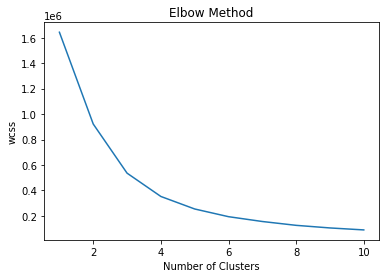

In [62]:
# X = pivot_clusters.iloc[:, [2,4]].values
X = pivot_clusters[['health', 'culture']].values

# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()


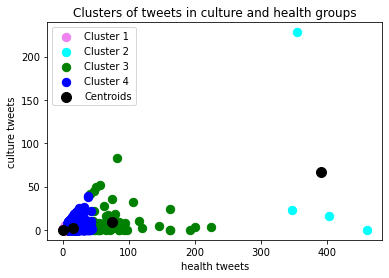

In [63]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)

# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=70, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=70, c='cyan', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=70, c='green', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=70, c='blue', label= 'Cluster 4')
# plt.scatter(X[Y_kmeans==4, 0], X[Y_kmeans==4, 1], s=70, c='magenta', label= 'Cluster 5')
# plt.scatter(X[Y_kmeans==5, 0], X[Y_kmeans==5, 1], s=100, c='pink', label= 'Cluster 6')
# plt.scatter(X[Y_kmeans==6, 0], X[Y_kmeans==6, 1], s=100, c='yellow', label= 'Cluster 7')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black', label='Centroids' )
plt.title('Clusters of tweets in culture and health groups')
plt.xlabel('health tweets')
plt.ylabel('culture tweets')
plt.legend()
plt.show()

### KMeans with PCA

In [64]:
from sklearn.decomposition import PCA

In [65]:
seg = pivot_clusters.copy()
# seg = seg.drop

pca = PCA()
pca.fit(seg)

PCA()

In [66]:
pca.explained_variance_ratio_

array([8.85196164e-01, 1.00460496e-01, 1.43433394e-02, 3.57529266e-32,
       2.50630194e-34])

Text(0, 0.5, 'cummulative explained variance')

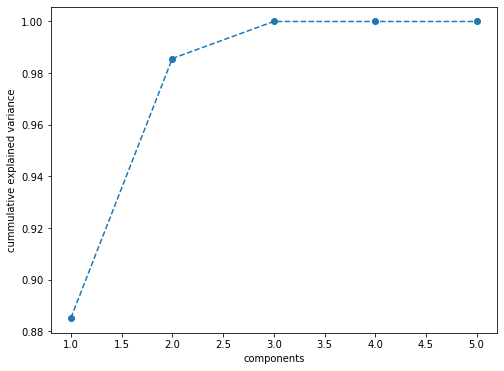

In [67]:
plt.figure(figsize = (8,6))
plt.plot(range(1,6), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')

In [68]:
pca = PCA(n_components = 2)
pca.fit(seg)

PCA(n_components=2)

In [69]:
scores = pca.transform(seg)

Text(0, 0.5, 'wcss')

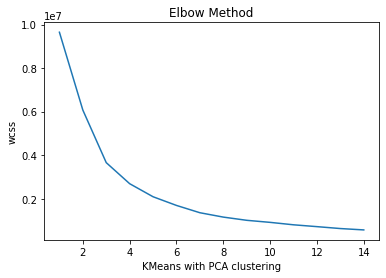

In [70]:
# Elbow Method
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(scores)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('Elbow Method')
plt.xlabel('KMeans with PCA clustering')
plt.ylabel('wcss')

In [71]:
n = 4
kmeans_pca = KMeans(n_clusters = n, init = 'k-means++', random_state = 0)
kmeans_pca.fit(scores)

KMeans(n_clusters=4, random_state=0)

In [72]:
c = pd.concat([seg.reset_index(drop = True), pd.DataFrame(scores)], axis = 1)
c.columns.values[-2:] = ['component1', 'component2']
c['segment_kmeans_pca'] = kmeans_pca.labels_

In [73]:
c.tail()

,economic,social,culture,health,total,component1,component2,segment_kmeans_pca
62993,0,1,0,0,1,-2.246963,-0.744814,0
62994,0,1,0,0,1,-2.246963,-0.744814,0
62995,0,1,0,0,1,-2.246963,-0.744814,0
62996,0,1,0,0,1,-2.246963,-0.744814,0
62997,0,0,0,1,1,-2.268571,0.664631,0


Text(0.5, 1.0, 'Clusters by PCA')

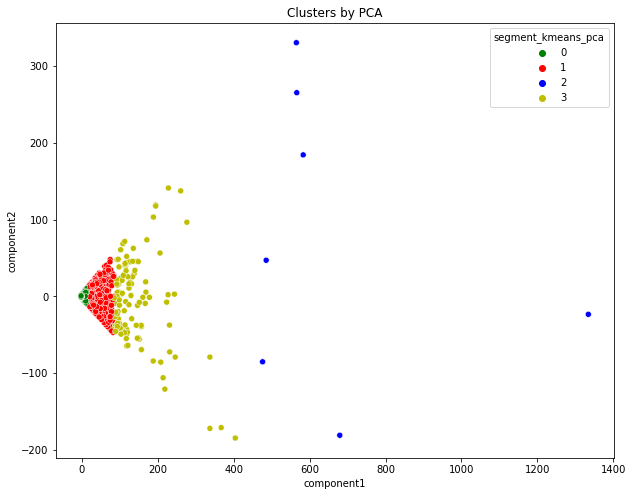

In [74]:
plt.figure(figsize = (10,8))
sns.scatterplot(x = c['component1'], y = c['component2'], hue = c['segment_kmeans_pca'], palette = ['g', 'r', 'b', 'y'])
plt.title('Clusters by PCA')

## Time Series Analysis

In [75]:
'''Get tweets full details: must get ~ time stamp'''

def pivoted_df_with_ts(paths):
    global dataframes
    dataframes = []
    for path in paths:
        frame = pd.read_csv(path)

        names = path.split('/')
        names= names[-1]
        names = names.split('_')
        global name
        name = names[0]

        df = pd.DataFrame()
        df['tweets'] = frame['text']
        df['favorites'] = frame['favorites']
        df['retweets'] = frame['retweets']
        df['entities'] = frame['entities']
        df['created_at'] = frame['created_at']
        df.insert(0, 'screen_name', name)
        
        dataframes.append(df)
    mega = pd.concat(dataframes)
    return mega

In [76]:
file_paths = ['/home/ada/10academy/training /week2/monday/csvs/mega csvs tweets/@' + name + '_tweets.csv' for name in n]

tweets = pivoted_df_with_ts(file_paths)
tweets.shape

TypeError: 'int' object is not iterable

In [ ]:
tweets.head()

In [ ]:
'''create a scores column, sort values by scores, do analysis on top 500 tweets'''

tweets['scores'] = tweets['favorites'] + tweets['retweets']
top_tweets = tweets.sort_values(by = 'scores', ascending = False)
# top_tweets = top_tweets.head(500)
top_tweets.head()

In [ ]:
# print('all tweets tweeps:', len(tweets['screen_name'].unique()))
# print('top 500 tweets tweeps', len(top_tweets['screen_name'].unique()))

* plan is to explore the trends in tweets volumes, maybe the tweets can be grouped into time stamps, then see the transition of volume of these tweets from one time to another.

In [ ]:
'''explore the time stamps and create groups'''
top_tweets['created_at'] = pd.to_datetime(top_tweets['created_at'])

In [ ]:
top_tweets.head()

In [ ]:
top_tweets.info()

In [ ]:
top_tweets['created_at'].describe()

* Earliest tweet: ***25th June 2014***
* Latest tweet ***22nd July 2020***
* day with highest number ***21st July 2020***


Must say the users are a mixture of active and super dormant ones

In [ ]:
'''get the years, months and day columns'''

top_tweets = top_tweets.set_index('created_at')

# Add columns with year, month, and weekday name
top_tweets['Year'] = top_tweets.index.year
top_tweets['Month'] = top_tweets.index.month
top_tweets['Weekday'] = top_tweets.index.weekday_name


top_tweets.head()

### 1. Weekday Analysis overall tweets

In [ ]:
# week day analysis
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weeks_df = top_tweets.groupby(['Weekday']).count().reindex(cats) 
# weeks_df = top_tweets.groupby(['Weekday']).count() #count number of tweets, count is a string function, so let's drop the integers.
weeks_df = weeks_df[['tweets']]
weeks_df

In [ ]:
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sorterIndex = dict(zip(sorter,range(len(sorter))))

weeks_df['Day_id'] = weeks_df.index
weeks_df['Day_id'] = weeks_df['Day_id'].map(sorterIndex)
weeks_df.sort_values('Day_id', inplace=True)


# now lets see some of the busy days of the week.
plt.figure(figsize=(12,10))
sns.lineplot(x = weeks_df.Day_id, y = weeks_df.tweets)
plt.title('A lineplot plot showing tweets distribution across the weeks')
plt.xticks(rotation=45)
plt.xlabel('day of the week')
plt.ylabel('Number of tweets')

The plot is just all over the place.

This plot is just all over the place.
* Highest number of tweets: ***Tuesday***
* Lowest tweet rate: ***Thursday***

The trend generally: Lowest tweeting activity on Thursday, then the frequency increases slowly upto Tuesday where the max is recorded then gradual droping to Thurday.

The spike in Tuesday is as a result of biasness due to the day I scrapped the tweets which was on Wednesday. Thus by default the highest number of tweets will be Tuesday's, and lowest will be Thursday in the week flow: Tuesday, Monday, Sunday, Saturday, Friday, Thursday

### 2. Monthly Analysis

In [ ]:
months_df = top_tweets.groupby(['Month']).count()
# weeks_df = top_tweets.groupby(['Weekday']).count() #count number of tweets, count is a string function, so let's drop the integers.
months_df = months_df[['tweets']]
months_df

In [ ]:
# now lets see some of the busy Months.
plt.figure(figsize=(12,10))
sns.barplot(x = months_df.index, y = months_df.tweets)
plt.title('A barplot plot showing tweets distribution across the months')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Number of tweets')

Most of the tweets are around July. This is a biased data issue. The tweets are each users' most recent 500 tweets, so by default most tweets are from July, the current month we're in. 

The trend explanation is the same as in the week days analysis.

### 3. Tweet classes and their trends

[Back to top](#Cluster-and-Time-Series-Analysis)